In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster

# Compartment, CompartmentPrototype and Probes Setup

## Basic compartment with probes
We create the simplest possible network consisting only of a single bias-driven compartment. The compartment voltage integrates the bias current and when it exceeds the membrane threshold, the compartment produces a spike, the voltage resets and the integration starts all over again.
To monitor the compartment dynamics, we probe and plot the compartmentVoltage and spike output of the compartment.

![Basic Compartment with Probe](figures/jupyter_basic_compartment_with_probe.png)

### Create compartment

In [3]:
# Create an empty network.
net = nx.NxNet()
# Create a compartment prototype from which one or more compartments can be created.
# We set the compartmentVoltageDecay to 0 which results in an integrate-and-fire neuron behavior.
cxp = nx.CompartmentPrototype(biasMant=1000,
                              biasExp=6,
                              vThMant=10000,                              
                              compartmentVoltageDecay=0,
                              functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
# Create compartment from compartment prototype
cx = net.createCompartment(cxp)

### Create compartment probes

In [4]:
# Create optional probe conditions that determine at which interval probes are evaluated and when probing starts.
vPc = nx.IntervalProbeCondition(dt=1, tStart=1)
sPc = nx.SpikeProbeCondition(dt=1, tStart=1)
# Create a probe for the membrane potential and the output spikes.
vProbe = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE, probeConditions=vPc)
sProbe = cx.probe(nx.ProbeParameter.SPIKE, probeConditions=sPc)

### Run network

In [5]:
# Run network for 100 time steps and then disconnect from the board in order to free resources.
net.run(100)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.00s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.02s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.04s)


### Show results

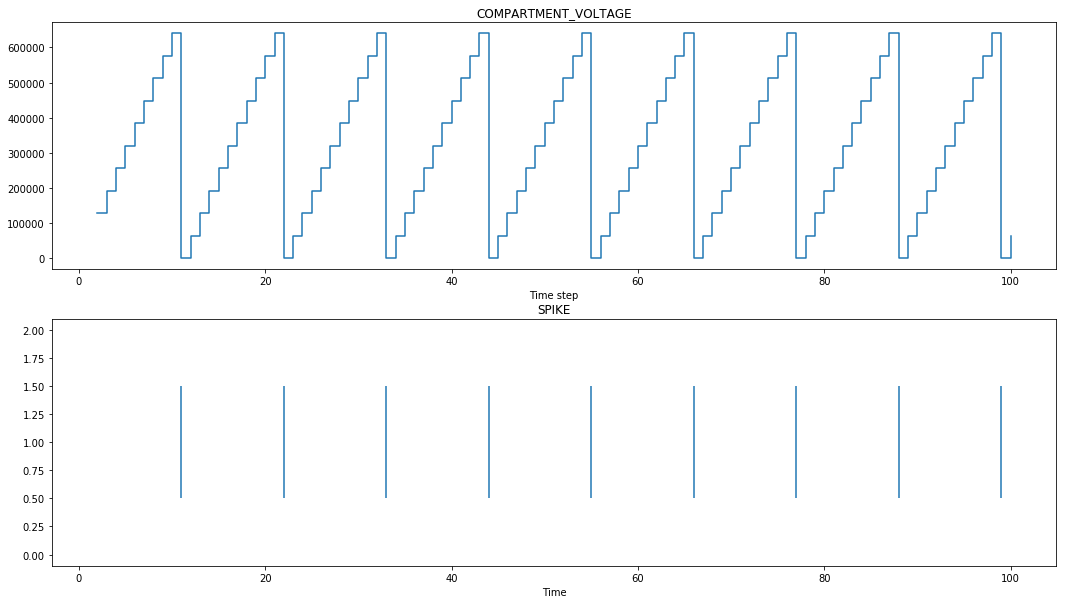

In [6]:
fig = plt.figure(1, figsize=(18,10))
# Plot compartmentVoltage
ax0 = plt.subplot(2,1,1)
vProbe[0].plot()
plt.title('COMPARTMENT_VOLTAGE')
# Plot spike train
ax1 = plt.subplot(2,1,2)
sProbe[0].plot()
ax1.set_xlim(ax0.get_xlim())
plt.xlabel('Time')
plt.title('SPIKE')
plt.show()

# As the compartmentVoltage exceeds its threshold at vThMant*2**6, the voltage resets and restarts integrating
# the bias current. Whenever the threshold is exceeded, the compartment emits a spike.

## Compartment with compartmentVoltageDecay
Next, we demonstrate the effect of a non-zero decay constant for the compartment voltage. As a refernce we also show the compartment dynamics without decay. Whenever, we deal with multiple compartments it is convenient to create and logically group them through a CompartmentGroup.

![Compartment with Voltage Decay](figures/jupyter_compartment_with_voltage_decay.png)

### Create compartmentGroup

In [7]:
net = nx.NxNet()
# Create prototypes for compartments with and without compartmentVoltageDecay. The decay constant is computed from the
# inverse time constant tauDecayV mapped to the 12 bit dynamic range of compartmentVoltageDecay.
cxpRef = nx.CompartmentPrototype(biasMant=1000,
                                 biasExp=6,
                                 vThMant=10000,                              
                                 compartmentVoltageDecay=0,
                                 functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
tauDecayV = 15
cxpDecayV = nx.CompartmentPrototype(biasMant=1000,
                                   biasExp=6,
                                   vThMant=10000,                              
                                   compartmentVoltageDecay=int(1/tauDecayV*2**12),
                                   functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
# Create compartmentGroup from the two different prototypes. Here prototype can be a single or list of prototypes.
# If a list is provided, a prototypeMap is required which maps the prototypes to the 0..size-1 compartments in the group.
cxGrp = net.createCompartmentGroup(size=2, prototype=[cxpRef, cxpDecayV], prototypeMap=[0, 1])

### Create compartment probes and run network

In [8]:
# The probe method of a compartmentGroup returns a ProbeSet object which allows to conveniently group multiple probes
# of the same type.
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

net.run(100)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.02s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.05s)


### Show results

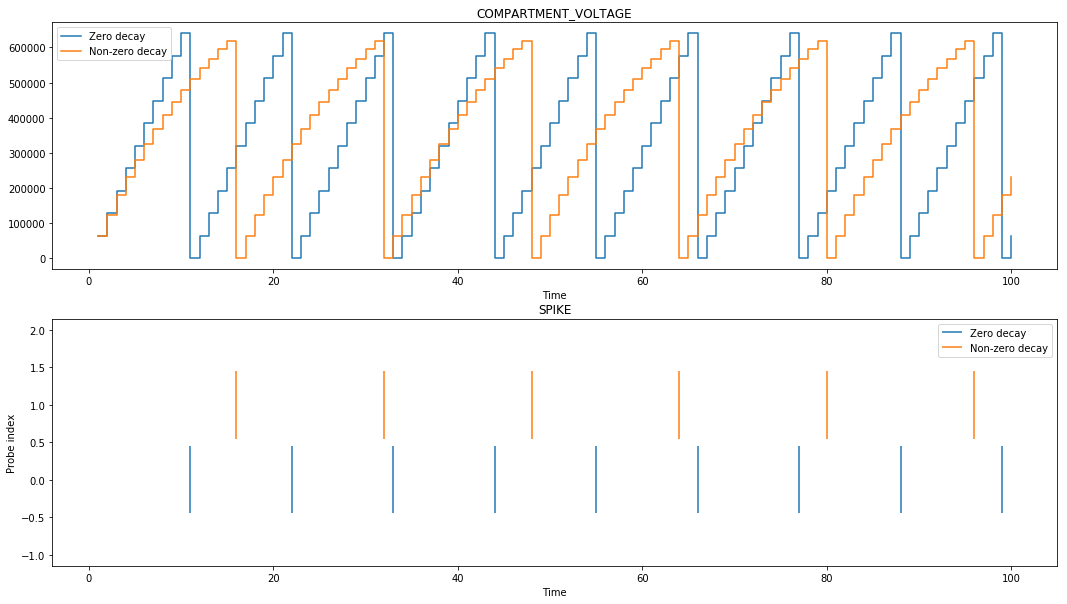

In [9]:
fig = plt.figure(2, figsize=(18,10))
# Plot compartmentVoltages
ax0 = plt.subplot(2,1,1)
vh = vProbes.plot()
# Plot spike trains
ax1 = plt.subplot(2,1,2)
sh = sProbes.plot(colors=[vh[0].get_color(), vh[1].get_color()])
ax1.set_xlim(ax0.get_xlim())
ax0.legend(vh, ['Zero decay', 'Non-zero decay'])
ax1.legend(sh, ['Zero decay', 'Non-zero decay'])
plt.show()

As a result of the compartmentVoltageDecay, the compartmentVoltage of the second compartment increases sublinearly and therefore spikes at a lower frequency.

## Compartment with (stochastic) compartmentVoltage
Uniform random noise can either be injected into the compartmentCurrent or compartmentVoltage via an LFSR random number generator. Here, we demonstrate randomization of the compartmentVoltage. Adding uniform random noise over time has the same effect as adding Gaussian noise.

![Compartment with Stochastic Voltage](figures/jupyter_compartment_with_stochastic_voltage.png)


### Create compartmentGroup

In [10]:
net = nx.NxNet()
# Create prototype for compartment without noise injection.
cxp0 = nx.CompartmentPrototype(biasMant=50,
                               biasExp=6,
                               vThMant=1000,                              
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=0)
# Create prototype for compartment with stochastic compartmentVoltage. Due to the absence of a compartmentVoltageDecay
# and presence of a bias current, the compartmentVoltage changes by biasMant*2**biasExp + (LFSR()-2**7 +
# noiseMant*2**6)*2**(noiseExp-7) every time step, where LFSR() returns a random unsigned 8 bit integer.
# Since the noise mantissa and exponent are core-global settings, we force the two compartments using these prototypes
# onto two different logical neuro cores.
cxp1 = nx.CompartmentPrototype(biasMant=50,
                               biasExp=6,
                               vThMant=1000,                              
                               enableNoise=1,
                               noiseMantAtCompartment=1,
                               noiseExpAtCompartment=11,
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=1)
# Create compartmentGroup from the two different prototypes.
cxGrp = net.createCompartmentGroup(size=2, prototype=[cxp0, cxp1], prototypeMap=[0, 1])

### Create compartment probes and run network

In [11]:
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

net.run(100)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.02s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.05s)


### Show results

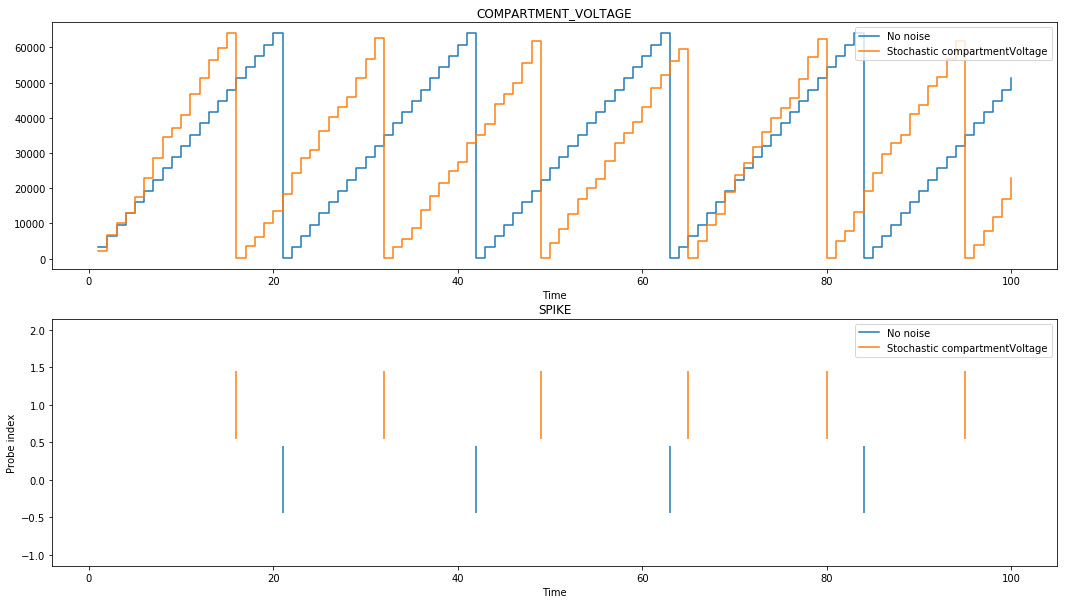

In [12]:
fig = plt.figure(3, figsize=(18,10))
# Plot compartmentVoltages
ax0 = plt.subplot(2,1,1)
vh = vProbes.plot()
# Plot spike trains
ax1 = plt.subplot(2,1,2)
sh = sProbes.plot(colors=[vh[0].get_color(), vh[1].get_color()])
ax1.set_xlim(ax0.get_xlim())
ax0.legend(vh, ['No noise', 'Stochastic compartmentVoltage'])
ax1.legend(vh, ['No noise', 'Stochastic compartmentVoltage'])
plt.show()

# The first compartment integrates a constant bias current without compartmentVoltageDecay and therefore spikes at a
# constant frequency. The second compartment integrates a constant bias current with a superimposed noise current every
# time step. As a result, its compartmentVoltage has a strong random walk component.

## Compartment with (stochastic) refractoryDelay
Next, we demonstrate the effect of a non-zero refractoryDelay. When the refractoryDealy is non-zero, a compartment becomes inactive after a spike for the duration of the refractoryDelay. Besides randomizing the compartmentCurrent and compartmentVoltage, the refractoryDelay can also be randomized by adding uniform random noise. With such randomization the refractory period will vary after each spike.

![Compartment with Stochastic Refractory Delay](figures/jupyter_compartment_with_stochastic_refractory_delay.png)

### Create compartmentGroup

In [13]:
net = nx.NxNet()
# Create prototype for compartment with static refractoryDelay of 10.
cxp0 = nx.CompartmentPrototype(biasMant=1000,
                               biasExp=6,
                               vThMant=10000,                              
                               refractoryDelay=10,
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=0)
# Create prototype for compartment with stochastic refractoryDelay of 10 + (LFSR()-2**7 + noiseMant*2**6)*2**(noiseExp-7)
# where LFSR() returns a random unsigned 8 bit integer. Since the noise mantissa and exponent are core-global settings, we
# force the two compartments using these prototypes onto two different logical neuro cores.
cxp1 = nx.CompartmentPrototype(biasMant=1000,
                               biasExp=6,
                               vThMant=10000,                              
                               refractoryDelay=10,
                               thresholdBehavior=nx.COMPARTMENT_THRESHOLD_MODE.SPIKE_AND_RANDOMIZE_REFRACTORY_DELAY,
                               noiseMantAtRefractoryDelay=0,
                               noiseExpAtRefractoryDelay=2,
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=1)
# Create compartmentGroup from the two different prototypes.
cxGrp = net.createCompartmentGroup(size=2, prototype=[cxp0, cxp1], prototypeMap=[0, 1])

### Create compartment probes and run network

In [14]:
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

net.run(100)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.02s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.04s)


### Show results

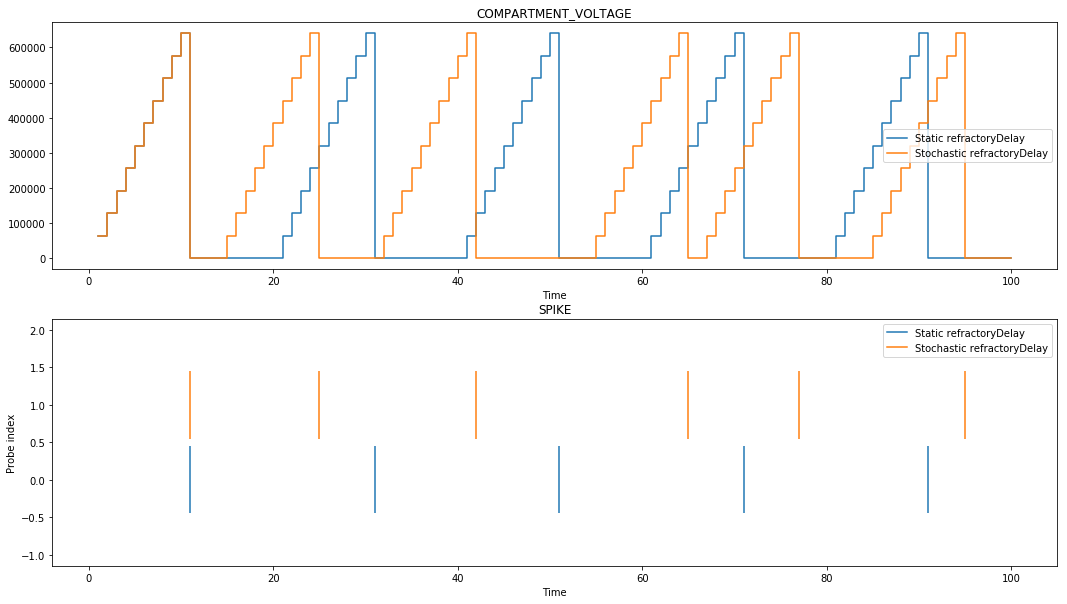

In [15]:
fig = plt.figure(4, figsize=(18,10))
# Plot compartmentVoltages
ax0 = plt.subplot(2,1,1)
vh = vProbes.plot()
# Plot spike trains
ax1 = plt.subplot(2,1,2)
sh = sProbes.plot(colors=[vh[0].get_color(), vh[1].get_color()])
ax1.set_xlim(ax0.get_xlim())
ax0.legend(vh, ['Static refractoryDelay', 'Stochastic refractoryDelay'])
ax1.legend(vh, ['Static refractoryDelay', 'Stochastic refractoryDelay'])
plt.show()

# Both compartments integrate the bias current at the same rate and spike when the respective membrance potential exceeds
# the threshold. However, whereas the refractoryDelay of the first neuron always lasts for 10 time steps, the
# refractoryDelay of the second neuron varies stochastically around a baseline of 10 time steps.

## Set membrane potential threshold VTh
At the NxCore level, there are two ways of configuring vth: set vthProfileCfg and set somaStates. For setting details, please refer to nxcore/tutorial_10_membrane_potential_threshold.py.

At the NxNet level, vth can be configured as a discrete parameter by setting useDiscreteVTh. When useDiscreteVTh is disabled, vth is set for each threshold using the shared vthProfileCfg. When useDiscreteVTh is enabled, vth is discretely set without using the shared vthProfileCfg. Use of discrete vth comes at a cost of execution time and power. With shared vthProfileCfg, a maximum of 8 thresholds can be created when useDiscreteVTh is disabled. With useDiscreteVTh enabled, more than 8 thresholds can be configured without sharing vthProfileCfg. In the example below, 10 compartments are created with useDiscreteVTh enabled, each compartment has a different membrane potential threshold.

### Create compartments

In [16]:
net = nx.NxNet()

# create one compartment with discrete vth setting
pDiscrete = nx.CompartmentPrototype(biasMant=100,
                                    biasExp=6,
                                    vThMant=900,
                                    functionalState=2,
                                    compartmentCurrentDecay=409,
                                    compartmentVoltageDecay=256,
                                    useDiscreteVTh=1,
                                    logicalCoreId=0)
cxDiscrete = net.createCompartment(pDiscrete)

# create one compartment with shared vth setting
pShared = nx.CompartmentPrototype(biasMant=50,
                                  biasExp=6,
                                  vThMant=700,
                                  functionalState=2,
                                  compartmentCurrentDecay=409,
                                  compartmentVoltageDecay=256,
                                  useDiscreteVTh=0,
                                  logicalCoreId=0)
cxShared = net.createCompartment(pShared)

# create 10 compartments with discrete vth setting, each has different membrane potential 
# threshold specified in voltageVec
cxGrp = net.createCompartmentGroup(size=0)
voltageVec = list(range(800, 1300, 50))
numCompartments = len(voltageVec)

for cxId in range(0, numCompartments):
    # Prototypes
    voltageVal = voltageVec[cxId]
    pbasic = nx.CompartmentPrototype(biasMant=100,
                                     biasExp=6,
                                     vThMant=voltageVal,
                                     functionalState=2,
                                     compartmentCurrentDecay=409,
                                     compartmentVoltageDecay=256,
                                     useDiscreteVTh=1,
                                     logicalCoreId=0)
    # Group of compartments
    cxGrp.addCompartments(net.createCompartment(pbasic))

### Create compartment probes and run network

In [17]:
(discreteVProbes, discreteSProbes) = cxDiscrete.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,nx.ProbeParameter.SPIKE])

(sharedVProbes, sharedSProbes) = cxShared.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,nx.ProbeParameter.SPIKE])

(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

net.run(100)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.03s)
INFO:DRV:      Processing timeSeries... Done (0.02s)
INFO:DRV:  N2Driver: Finished (0.06s)


### Show results

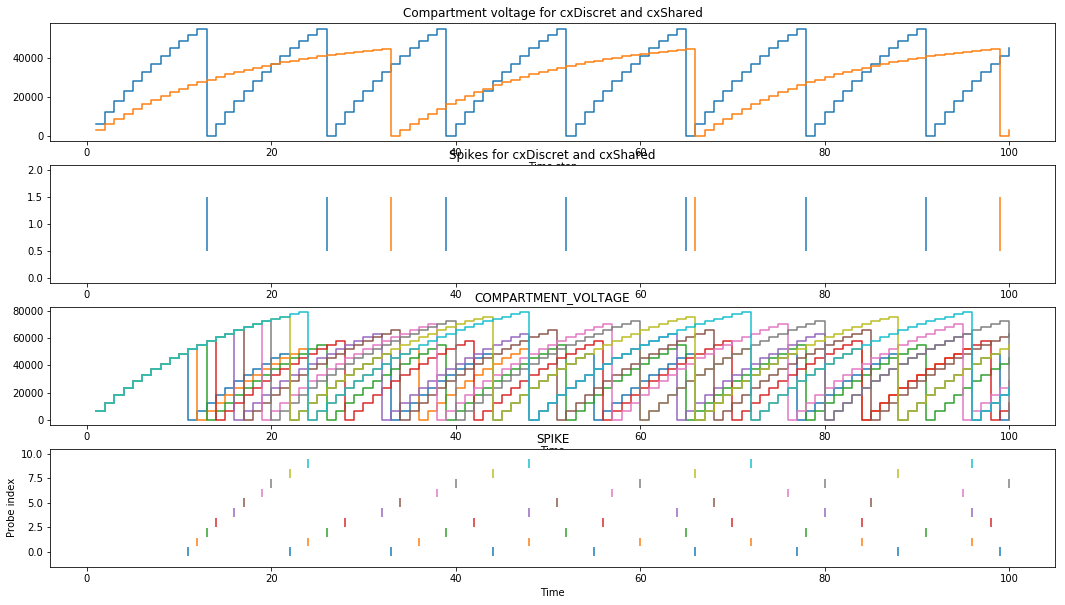

In [18]:
fig = plt.figure(5, figsize=(18,10))
# Plot compartmentVoltages for cxDiscrete and cxShared
ax1 = plt.subplot(4, 1, 1)
plt.title('Compartment voltage for cxDiscret and cxShared')
discreteVProbes.plot()
vh0 = sharedVProbes.plot()
color=vh0[0].get_color()

# Plot spike trains for cxDiscrete and cxShared
ax2 = plt.subplot(4, 1, 2)
plt.title('Spikes for cxDiscret and cxShared')
discreteSProbes.plot()
vh1 = sharedSProbes.plot()
vh1[0].set_color(color)
ax2.set_xlim(ax1.get_xlim())

# Plot compartmentVoltages for cxGrp
ax3 = plt.subplot(4, 1, 3)
vh = vProbes.plot()

# Plot spike trains for cxGrp
ax4 = plt.subplot(4, 1, 4)
sProbes.plot(colors=[vh[0].get_color(),vh[1].get_color(),vh[2].get_color(),vh[3].get_color(),vh[4].get_color(),
                     vh[5].get_color(),vh[6].get_color(),vh[7].get_color(),vh[8].get_color(),vh[9].get_color()])
ax4.set_xlim(ax1.get_xlim())
plt.show()

# Compartment cxDiscrete and cxShared are created with vth being set with and without useDiscreteVTh being enabled
# respectively. 10 compartments in cxGrp are indivisually created without sharing vthProfileCfg, each has its own membrane
# potential threshold

.. code-links:: python clear